### Import Libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() +'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [3]:
# Import some other useful libraries or functions
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
# Check if the notebook is running on Kaggle or locally
import os
onKaggle = False
if ('PWD'in os.environ):
    onKaggle = True
print(onKaggle)

True


### Create train,validation and test sets

In [5]:
data_folder = "data/challenge"
if onKaggle:
    data_folder = "/kaggle/input/an2dl-ch2-data/challenge"

training_data = np.load(f'{data_folder}/training_data.npy')
categories = np.load(f'{data_folder}/categories.npy')
valid_periods = np.load(f'{data_folder}/valid_periods.npy')

print(f"Training data shape: {training_data.shape}")
print(f"Valid periods shape: {valid_periods.shape}")
print(f"categories shape: {categories.shape}")

Training data shape: (48000, 2776)
Valid periods shape: (48000, 2)
categories shape: (48000,)


In [6]:
# Split the data into training and validation sets
X_train_raw, X_validation_raw, categories_train, categories_validation, valid_periods_train, valid_periods_validation = train_test_split(
    training_data,
    categories,
    valid_periods,
    test_size=0.1, 
    shuffle=True, 
    stratify=categories)

In [7]:
def build_sequences_dataset(series_dataset, valid_periods, categories, valid_categories, window=200, stride=50, telescope=50, skip_threshold=150)-> tuple[np.array, np.array]:
    assert window % stride == 0

    sequences = []
    targets = []

    for i in range(0, len(series_dataset)):
        # get the ts from the right categories
        if categories[i] in valid_categories:
            start, end = valid_periods[i]

            # Skip short sequences
            if end - start < skip_threshold:
                continue
            series = series_dataset[i,start:end]
            padding_len = (window + telescope) - series.shape[0] % (window + telescope)

            # Padding
            if (window + telescope - padding_len) > skip_threshold:
                z_padding = np.zeros(padding_len)
                series = np.concatenate((z_padding, series), axis=-1) # concatenate by columns (extend columns)

            seq, targ = split_series(series, window, stride, telescope)
            # Building the training and target data
            sequences += seq
            targets += targ

    return np.array(sequences).astype(np.float32), np.array(targets).astype(np.float32)


def split_series(time_series, window, stride, telescope):
    sequences = []
    targets = []
    for i in range(0, len(time_series) - (window + telescope) + 1, stride):
        sequences.append(time_series[i:i+window])
        targets.append(time_series[i+window:i+window+telescope])

    return sequences, targets

In [8]:
window = 200
stride = 20
thresh = 150
telescope = 9 # prediction steps

# categories from which to extract time series
valid_categories = ['A', 'B', 'C', 'D', 'E', 'F']

X_train, y_train = build_sequences_dataset(X_train_raw, valid_periods_train, categories_train, valid_categories, window, stride, telescope, thresh)
X_val, y_val = build_sequences_dataset(X_validation_raw, valid_periods_validation, categories_validation, valid_categories, window, stride, telescope, thresh)

X_train.shape, y_train.shape

((120887, 200), (120887, 9))

TensorShape([200])

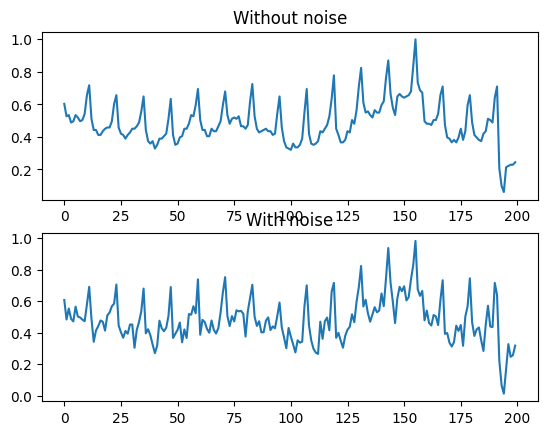

In [9]:
train_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_tf = tf.data.Dataset.from_tensor_slices((X_val,y_val))
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def custom_augment(x, labels):
    # Randomly apply transformation (color distortions) with probability p.
    x = random_apply(jitter, x, p=0.4)
    return (x, labels)

@tf.function
def jitter(x, s=0.05):
    zeroes = tf.where(x!=0)[0][0]
    x_n = x[zeroes:]
    myNoise = tf.random.normal(stddev=s, shape=tf.shape(x_n))
    x_noise = x_n + myNoise
    x = x = tf.concat((x[:zeroes], x_noise), axis = 0)
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

train_tf = (
    train_tf
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(512)
    .prefetch(AUTO)
)

validation_tf = (
    validation_tf
    .shuffle(100)
    .batch(512)#BS
    .prefetch(AUTO)
)

x = X_train[0]
x_n = x[tf.where(x!=0)[0][0]:]
myNoise = tf.random.normal(stddev=0.05, shape=x_n.shape)
x_noise = x_n + myNoise
x_final = x_noise

figure, axis = plt.subplots(2, 1)

# For Sine Function
axis[0].plot(x_n)
axis[0].set_title("Without noise")

# For Cosine Function
axis[1].plot(x_noise)
axis[1].set_title("With noise")

x_final.shape

In [10]:
input_shape = np.expand_dims(X_train[0], axis=1).shape
output_shape = y_train[0].shape
print(input_shape, output_shape)

(200, 1) (9,)


### Load public/private test sets

In [11]:
# Load the datasets not available during challenge but added for completeness

data_folder_1 = "data/public_test"
data_folder_2 = "data/private_test"
if onKaggle:
    data_folder_1 = "/kaggle/input/an2dl-ch2-data/public_test"
    data_folder_2 = "/kaggle/input/an2dl-ch2-data/private_test"

y_test_public = np.load(f'{data_folder_1}/phase1.npy')
categories_1 = np.load(f'{data_folder_1}/categories.npy')
X_test_public = np.load(f'{data_folder_1}/history.npy')

y_test_private = np.load(f'{data_folder_2}/phase2.npy')
categories_2 = np.load(f'{data_folder_2}/categories.npy')
X_test_private = np.load(f'{data_folder_2}/history.npy')

In [12]:
print(f"y_public: {y_test_public.shape}, y_private {y_test_private.shape}")
# categories_1.shape, categories_2.shape
print(f"X_public: {X_test_public.shape}, X_private {X_test_private.shape}")

y_public: (60, 9), y_private (60, 18)
X_public: (60, 200), X_private (60, 200)


### Define some utility functions for training

In [13]:
def fit(model, X_train,y_train, X_val,y_val, epochs=70,batch_size = 64):
    
    cb = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0005, patience=18, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', min_delta=0.0005, patience=10, factor=0.1, min_lr=1e-6)
        ]
    history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(X_val, y_val),
        callbacks = cb
    ).history
    
    return history

def fit2(model, train_tf, validation_tf, epochs=70):
    
    cb = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0005, patience=18, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', min_delta=0.0005, patience=10, factor=0.1, min_lr=1e-6)
        ]
    history = model.fit(
        x = train_tf,
        # batch_size = batch_size,
        epochs = epochs,
        validation_data=validation_tf,
        shuffle=False,
        callbacks = cb
    ).history
    
    return history

def plot_history(history):
    best_epoch = np.argmin(history['val_loss'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Squared Error')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(18,3))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

def evaluate_model(model):
    
    train_loss, train_mae = model.evaluate(X_train,y_train)
    val_loss, val_mae = model.evaluate(X_val, y_val)
    public_test_loss, public_test_mae = model.evaluate(X_test_public, y_test_public)
    # private_test_loss, private_test_accuracy = model.evaluate(X_test_private, y_test_private)

    # Display the evaluation metrics for the model
    print("Model evaluation:")
    print("Train loss:", train_loss)
    print("Train mae:", train_mae)
    print("Validation loss:", val_loss)
    print("Validation mae:", val_mae)
    print("Public Test loss:", public_test_loss)
    print("Public Test mae:", public_test_mae)
    # print("Private Test loss:", private_test_loss)
    # print("Private Test accuracy:", private_test_accuracy)


### Build Bi_LSTM model

In [14]:
# da trainare prima con output 5 e poi con output 9
def build_CONV_LSTM_model(input_shape, output_shape,l2_lambda = 2e-5):

    input_layer = tfk.Input(shape=(input_shape), name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)
    x = tfkl.Dropout(0.1)(x)

    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1D(output_shape[0], 3, padding='same', name='output_layer')(x)
    x = tfkl.Flatten()(x)

    output_layer = tfkl.Dense(output_shape[0], activation = 'sigmoid', kernel_regularizer=tfk.regularizers.l2(l2_lambda))(x)

    # Construct the model by connecting input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss=tfk.losses.MeanSquaredError(),
        optimizer=tfk.optimizers.Adam(),
        metrics=["mae"],
    )
    
    return model

model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 output_layer (Conv1D)       (None, 200, 9)            3465      
                                                                 
 flatten (Flatten)           (None, 1800)              0         
                                                   

In [15]:
EPOCHS = 600
history = fit(model, X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=512)

Epoch 1/600


I0000 00:00:1709213540.200980      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 [==============================] - 19s 50ms/step - loss: 0.0138 - mae: 0.0794 - val_loss: 0.0091 - val_mae: 0.0633 - lr: 0.0010
Epoch 2/600
237/237 [==============================] - 11s 45ms/step - loss: 0.0086 - mae: 0.0604 - val_loss: 0.0080 - val_mae: 0.0575 - lr: 0.0010
Epoch 3/600
237/237 [==============================] - 11s 45ms/step - loss: 0.0081 - mae: 0.0577 - val_loss: 0.0077 - val_mae: 0.0562 - lr: 0.0010
Epoch 4/600
237/237 [==============================] - 11s 45ms/step - loss: 0.0077 - mae: 0.0561 - val_loss: 0.0077 - val_mae: 0.0574 - lr: 0.0010
Epoch 5/600
237/237 [==============================] - 11s 45ms/step - loss: 0.0075 - mae: 0.0548 - val_loss: 0.0074 - val_mae: 0.0554 - lr: 0.0010
Epoch 6/600
237/237 [==============================] - 11s 45ms/step - loss: 0.0073 - mae: 0.0543 - val_loss: 0.0069 - val_mae: 0.0520 - lr: 0.0010
Epoch 7/600
237/237 [==============================] - 11s 45ms/step - loss: 0.0071 - mae: 0.0531 - val_loss: 0.0070 - val_m

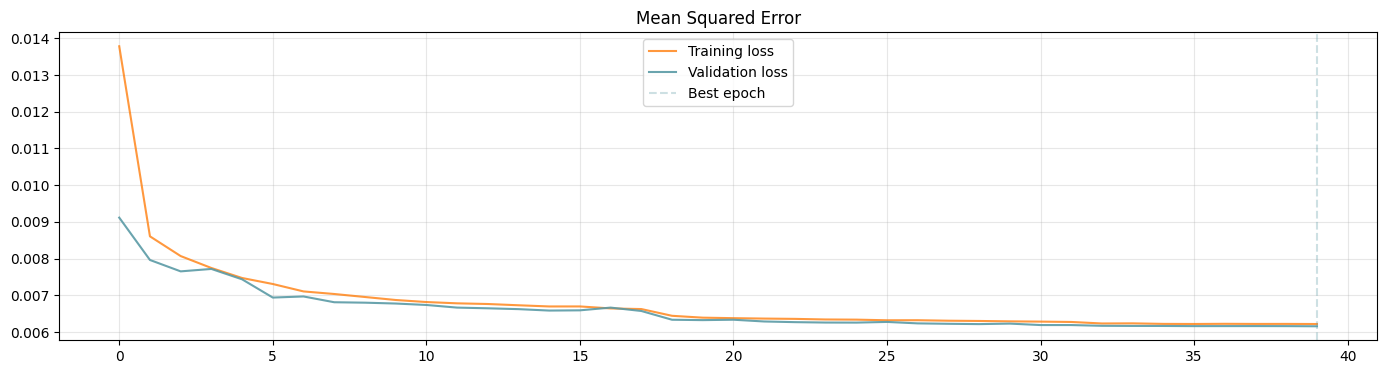

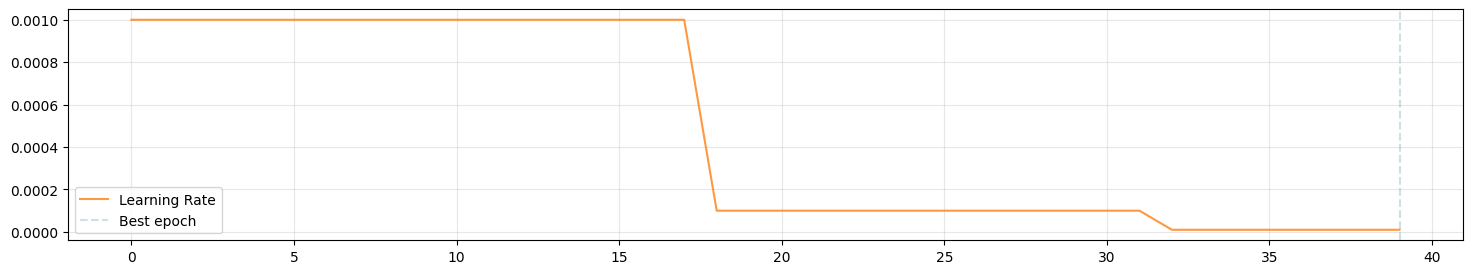

2/2 [==============================] - 0s 51ms/step - loss: 0.0063 - mae: 0.0572
Model evaluation:
Train loss: 0.006278180982917547
Train mae: 0.04908950254321098
Validation loss: 0.006287530530244112
Validation mae: 0.049093764275312424
Public Test loss: 0.0063306898809969425
Public Test mae: 0.05720259249210358


In [16]:
plot_history(history)
evaluate_model(model)

In [17]:
model = build_CONV_LSTM_model(input_shape, output_shape)
history = fit2(model, train_tf, validation_tf, epochs=EPOCHS)

Epoch 1/600
237/237 [==============================] - 15s 47ms/step - loss: 0.0154 - mae: 0.0852 - val_loss: 0.0092 - val_mae: 0.0627 - lr: 0.0010
Epoch 2/600
237/237 [==============================] - 11s 44ms/step - loss: 0.0091 - mae: 0.0633 - val_loss: 0.0082 - val_mae: 0.0582 - lr: 0.0010
Epoch 3/600
237/237 [==============================] - 11s 44ms/step - loss: 0.0085 - mae: 0.0606 - val_loss: 0.0078 - val_mae: 0.0563 - lr: 0.0010
Epoch 4/600
237/237 [==============================] - 11s 44ms/step - loss: 0.0082 - mae: 0.0593 - val_loss: 0.0077 - val_mae: 0.0560 - lr: 0.0010
Epoch 5/600
237/237 [==============================] - 11s 44ms/step - loss: 0.0079 - mae: 0.0580 - val_loss: 0.0075 - val_mae: 0.0561 - lr: 0.0010
Epoch 6/600
237/237 [==============================] - 11s 44ms/step - loss: 0.0077 - mae: 0.0570 - val_loss: 0.0074 - val_mae: 0.0557 - lr: 0.0010
Epoch 7/600
237/237 [==============================] - 11s 44ms/step - loss: 0.0075 - mae: 0.0564 - val_loss: 0.

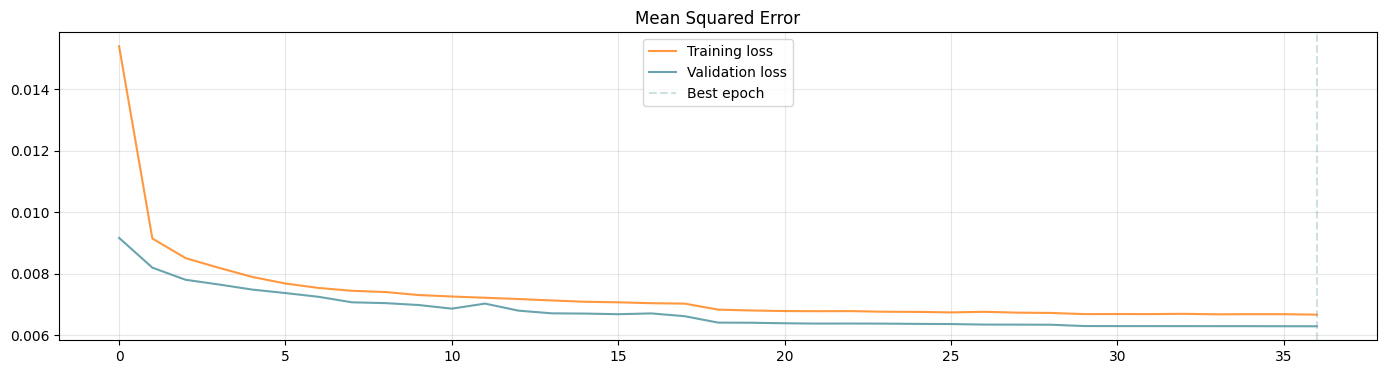

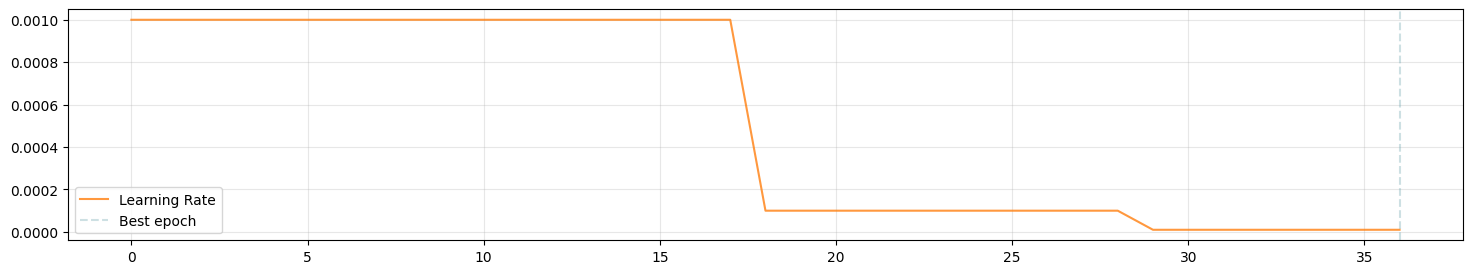

2/2 [==============================] - 0s 12ms/step - loss: 0.0066 - mae: 0.0588
Model evaluation:
Train loss: 0.00642086798325181
Train mae: 0.05005858466029167
Validation loss: 0.0064153228886425495
Validation mae: 0.05008430778980255
Public Test loss: 0.006638212129473686
Public Test mae: 0.05876648426055908


In [18]:
plot_history(history)
evaluate_model(model)

### Build second model

In [19]:
def build_model(input_shape, output_shape) :
    
    input_layer = tfkl.Input(shape=input_shape, name="Input")

    x = input_layer

    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(
        filters=256,
        kernel_size=3,
        padding="valid",
        activation="relu",
        name="Conv1D_1",
    )(input_layer)
    x = tfkl.Conv1D(
        filters=1024,
        kernel_size=3,
        padding="valid",
        activation="relu",
        name="Conv1D_2",
    )(x)
    x = tfkl.MaxPool1D(name="MaxPool1D_1")(x)

    lstm = tfkl.LSTM(
        units=512,
        return_sequences=True,
        return_state=False,
        name="LSTM_1",
    )(x)

    attention = tfkl.Dense(1, name="Dense_attention_1")(lstm)
    attention = tfkl.Flatten()(attention)
    attention = tfkl.Activation("softmax")(attention)
    attention = tfkl.RepeatVector(512)(attention)
    attention = tfkl.Permute([2, 1])(attention)
    attention = tfkl.Multiply()([lstm, attention])
    attention = tfkl.Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention)

    output_layer = tfkl.Dense(output_shape[0])(attention)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name="conv_LSTM_model")

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss=tfk.losses.MeanSquaredError(),
        optimizer=tfk.optimizers.Adam(),
        metrics=["mae"],
    )

    return model

model2 = build_model(input_shape, output_shape)
model2.summary()

Model: "conv_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 198, 256)             1024      ['Input[0][0]']               
                                                                                                  
 Conv1D_2 (Conv1D)           (None, 196, 1024)            787456    ['Conv1D_1[0][0]']            
                                                                                                  
 MaxPool1D_1 (MaxPooling1D)  (None, 98, 1024)             0         ['Conv1D_2[0][0]']            
                                                                                    

In [20]:
history2 = fit(model2, X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=64)

Epoch 1/600
1889/1889 [==============================] - 89s 45ms/step - loss: 0.0140 - mae: 0.0812 - val_loss: 0.0085 - val_mae: 0.0594 - lr: 0.0010
Epoch 2/600
1889/1889 [==============================] - 85s 45ms/step - loss: 0.0082 - mae: 0.0602 - val_loss: 0.0075 - val_mae: 0.0564 - lr: 0.0010
Epoch 3/600
1889/1889 [==============================] - 85s 45ms/step - loss: 0.0075 - mae: 0.0568 - val_loss: 0.0071 - val_mae: 0.0538 - lr: 0.0010
Epoch 4/600
1889/1889 [==============================] - 85s 45ms/step - loss: 0.0072 - mae: 0.0553 - val_loss: 0.0073 - val_mae: 0.0581 - lr: 0.0010
Epoch 5/600
1889/1889 [==============================] - 85s 45ms/step - loss: 0.0069 - mae: 0.0539 - val_loss: 0.0065 - val_mae: 0.0513 - lr: 0.0010
Epoch 6/600
1889/1889 [==============================] - 85s 45ms/step - loss: 0.0067 - mae: 0.0529 - val_loss: 0.0067 - val_mae: 0.0544 - lr: 0.0010
Epoch 7/600
1889/1889 [==============================] - 85s 45ms/step - loss: 0.0065 - mae: 0.0519 

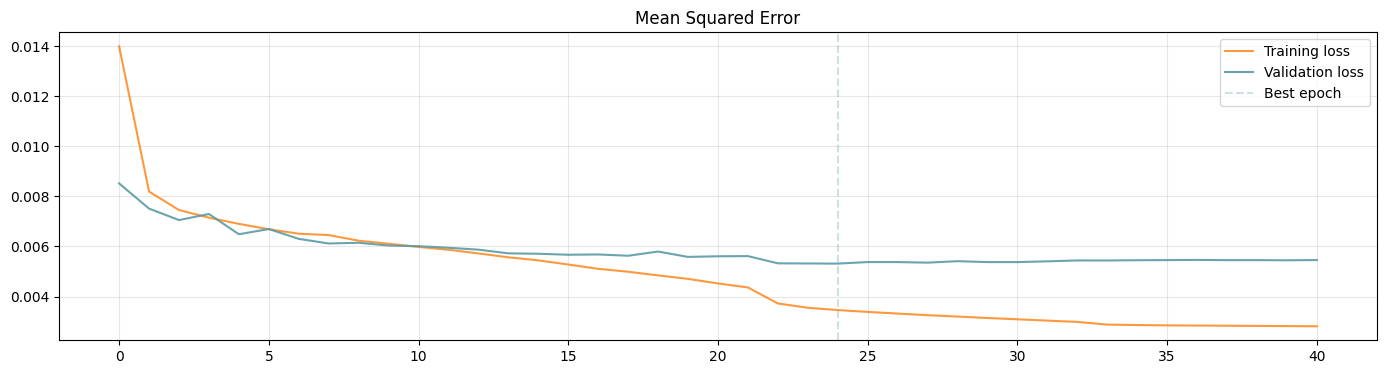

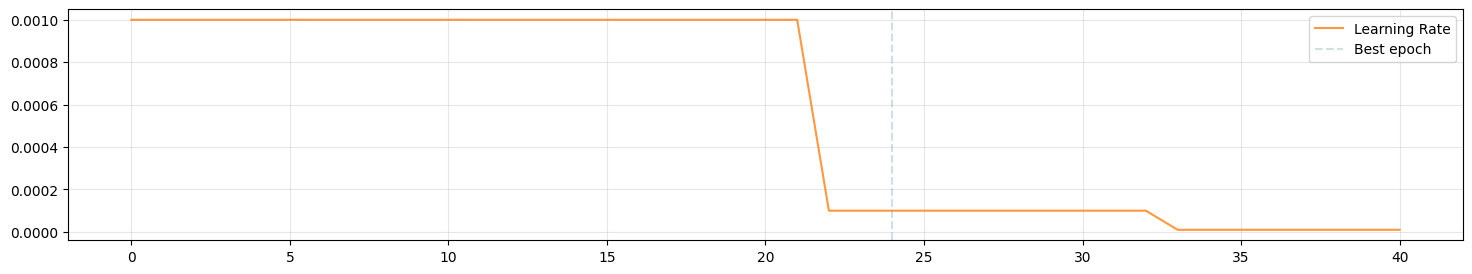

2/2 [==============================] - 0s 103ms/step - loss: 0.0059 - mae: 0.0533
Model evaluation:
Train loss: 0.0035460353828966618
Train mae: 0.03825695067644119
Validation loss: 0.005326562561094761
Validation mae: 0.04474136605858803
Public Test loss: 0.005949231795966625
Public Test mae: 0.053346727043390274


In [21]:
plot_history(history2)
evaluate_model(model2)